In [1]:
import os, sys
import pickle 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd
sys.path.insert(0,'../../LongTermEMG-master')

# 0. Prepare Data
* 20 participants total (exclude 10 and 11)
* data from 3DC armband (10 channels with 1000 Hz)
* 150 ms frames with overlap of 100 ms; band-pass filter between 20-495 Hz using fourth-order butterworth filter
* dataset dict
    * examples_training
    * labels_training
    * training_datetimes
    * highest_activations
    * examples_evaluation
    * labels_evaluation
    * evaluation_emg_timestamps
    * angles_and_timestamps
    * evaluation_datetimes
* feature_set_function = feature_extraction.getTSD applied to each window 
    * exclude 0 sEMG recordings 
    * [1] A. Al-Timemy, R. N. Khushaba, G. Bugmann, and J. Escudero, "Improving the Performance Against Force Variation of EMG Controlled Multifunctional Upper-Limb Prostheses for Transradial Amputees", IEEE Transactions on Neural Systems and Rehabilitation Engineering, DOI: 10.1109/TNSRE.2015.2445634, 2015.
    * [2] R. N. Khushaba, Maen Takruri, Jaime Valls Miro, and Sarath Kodagoda, "Towards limb position invariant myoelectric pattern recognition using time-dependent spectral features", Neural Networks, vol. 55, pp. 42-58, 2014.

In [2]:
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.prepare_dataset_utils import butter_bandpass_filter, \
    show_filtered_signal, load_timestamps_from_participant, get_angles_from_positions_3d_arm
from LongTermClassificationMain.PrepareAndLoadDataLongTerm import feature_extraction

In [3]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/PrepareAndLoadDataLongTerm")
print(os.listdir("../../"))
from handcrafted_features_prepare_from_from_raw_dataset import read_data_training

['longterm_dataset_3DC.zip', 'longterm_dataset_3DC', 'README.md', 'LongTermClassificationMain', 'datasets', 'TransferLearning', '.idea', 'Weights_TSD']


In [4]:
list_participant_training_1_to_skip = ["Participant0/Training1", "Participant0/Evaluation2", "Participant0/Evaluation3",
                                       "Participant2/Training1", "Participant2/Evaluation2", "Participant2/Evaluation3"]

In [5]:
# features_set_name = "TSD_features_set"
# feature_set_function = feature_extraction.getTSD
# read_data_training(path="../../datasets/longterm_dataset_3DC", features_set_name=features_set_name, \
#                 feature_set_function=feature_set_function)

# 1. Temporal-Spatial Descriptors Deep Network (TSD_DNN)
* input size = 128 x 3 x 1 = 384
* 3 fully connected layers with 200 neurons 
    * batch normalization
    * leaky ReLU (0.1)
    * dropout (0.5)
* mean cross entropy loss
* optimization = ADAM (lr = 0.002515, beta = (0.5, 0.999))
* lr_scheduler (1e-8)
* dataloader needs
    * examples_training
    * labels_training
   
   
### Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures
    * best_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict 
    * fine-tune from the previous training      

In [6]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_Spectrogram_fine_tuning
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [7]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_standard import test_TSD_DNN_on_training_sessions

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [8]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

algo_name = "11Gestures_standard_ConvNet_THREE_Cycles_TSD"
path_to_save_to = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"

filter_size = [200, 200, 200]      
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11                          
learning_rate = 0.002515

In [9]:
train_Spectrogram_fine_tuning(examples_datasets_train, labels_datasets_train, filter_size=None,
                              num_kernels=filter_size, number_of_cycle_for_first_training=4,
                              number_of_cycles_rest_of_training=4, path_weight_to_save_to=path_to_save_to,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
                              batch_size=128, spectrogram_model=False,
                              feature_vector_input_length=feature_vector_input_length,
                              learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2674, 385)
(4,)   1
SHAPE X:  (2829, 385)
(4,)   2
SHAPE X:  (2881, 385)
(4,)   3
SHAPE X:  (2821, 385)
(4,)   0
SHAPE X:  (2970, 385)
(4,)   1
SHAPE X:  (2859, 385)
(4,)   2
SHAPE X:  (2837, 385)
(4,)   3
SHAPE X:  (2783, 385)
(4,)   0
SHAPE X:  (2816, 385)
(4,)   1
SHAPE X:  (2888, 385)
(4,)   2
SHAPE X:  (2864, 385)
(4,)   3
SHAPE X:  (2835, 385)
Participant:  0
Session:  0
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
     

/home/laiy/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


train Loss: 0.01040122 Acc: 0.61054688
val Loss: 0.00583262 Acc: 0.40939597
New best validation loss: 0.005832620515119309
Epoch 1 of 500 took 0.188s
Epoch 1/499
----------
train Loss: 0.00508556 Acc: 0.81445312
val Loss: 0.01636657 Acc: 0.22483221
Epoch 2 of 500 took 0.173s
Epoch 2/499
----------
train Loss: 0.00393318 Acc: 0.86132812
val Loss: 0.00403322 Acc: 0.59731544
New best validation loss: 0.0040332178941509065
Epoch 3 of 500 took 0.184s
Epoch 3/499
----------
train Loss: 0.00368152 Acc: 0.8609375
val Loss: 0.01370335 Acc: 0.2147651
Epoch 4 of 500 took 0.179s
Epoch 4/499
----------
train Loss: 0.00292674 Acc: 0.89140625
val Loss: 0.00521586 Acc: 0.58053691
Epoch 5 of 500 took 0.186s
Epoch 5/499
----------
train Loss: 0.00281392 Acc: 0.89882812
val Loss: 0.01330785 Acc: 0.17785235
Epoch 6 of 500 took 0.178s
Epoch 6/499
----------
train Loss: 0.00249873 Acc: 0.90234375
val Loss: 0.00441098 Acc: 0.5704698
Epoch 7 of 500 took 0.188s
Epoch 7/499
----------
train Loss: 0.00244283 Acc

train Loss: 0.00468821 Acc: 0.81072443
val Loss: 0.00904234 Acc: 0.39365079
New best validation loss: 0.009042340233212426
Epoch 1 of 500 took 0.232s
Epoch 1/499
----------
train Loss: 0.00300455 Acc: 0.87926136
val Loss: 0.02243662 Acc: 0.27936508
Epoch 2 of 500 took 0.228s
Epoch 2/499
----------
train Loss: 0.00238833 Acc: 0.89559659
val Loss: 0.00644745 Acc: 0.55555556
New best validation loss: 0.006447452212136889
Epoch 3 of 500 took 0.231s
Epoch 3/499
----------
train Loss: 0.00216000 Acc: 0.91335227
val Loss: 0.00460074 Acc: 0.63809524
New best validation loss: 0.004600739479064942
Epoch 4 of 500 took 0.232s
Epoch 4/499
----------
train Loss: 0.00193003 Acc: 0.92329545
val Loss: 0.01963193 Acc: 0.35555556
Epoch 5 of 500 took 0.212s
Epoch 5/499
----------
train Loss: 0.00191848 Acc: 0.92578125
val Loss: 0.02435681 Acc: 0.24126984
Epoch 6 of 500 took 0.188s
Epoch 6/499
----------
train Loss: 0.00182858 Acc: 0.9243608
val Loss: 0.00628956 Acc: 0.56507937
Epoch 7 of 500 took 0.188s
E

train Loss: 0.00060186 Acc: 0.97585227
val Loss: 0.00023269 Acc: 0.97777778
Epoch 59 of 500 took 0.188s
Epoch 59/499
----------
train Loss: 0.00058635 Acc: 0.97691761
val Loss: 0.00030730 Acc: 0.96507937
Epoch 60 of 500 took 0.181s
Epoch 60/499
----------
train Loss: 0.00061123 Acc: 0.97585227
val Loss: 0.00026576 Acc: 0.97142857
Epoch 61 of 500 took 0.186s
Epoch 61/499
----------
train Loss: 0.00064643 Acc: 0.97265625
val Loss: 0.00030223 Acc: 0.95873016
Epoch 62 of 500 took 0.181s
Epoch 62/499
----------
train Loss: 0.00060215 Acc: 0.97443182
val Loss: 0.00027749 Acc: 0.97142857
Epoch 63 of 500 took 0.185s
Epoch 63/499
----------
train Loss: 0.00065153 Acc: 0.97194602
val Loss: 0.00024140 Acc: 0.97142857
Epoch    64: reducing learning rate of group 0 to 8.0480e-07.
Epoch 64 of 500 took 0.182s
Epoch 64/499
----------
train Loss: 0.00057729 Acc: 0.9740767
val Loss: 0.00023986 Acc: 0.97142857
Epoch 65 of 500 took 0.187s
Epoch 65/499
----------
train Loss: 0.00063646 Acc: 0.97265625
val 

train Loss: 0.00026969 Acc: 0.98899148
val Loss: 0.00015105 Acc: 0.99065421
Epoch 30 of 500 took 0.188s
Epoch 30/499
----------
train Loss: 0.00020926 Acc: 0.9921875
val Loss: 0.00023347 Acc: 0.97507788
Epoch 31 of 500 took 0.182s
Epoch 31/499
----------
train Loss: 0.00025193 Acc: 0.99005682
val Loss: 0.00013822 Acc: 0.98753894
Epoch 32 of 500 took 0.186s
Epoch 32/499
----------
train Loss: 0.00024475 Acc: 0.9897017
val Loss: 0.00013089 Acc: 0.98753894
Epoch    33: reducing learning rate of group 0 to 2.0120e-05.
Epoch 33 of 500 took 0.183s
Epoch 33/499
----------
train Loss: 0.00028106 Acc: 0.98899148
val Loss: 0.00011790 Acc: 0.99065421
Epoch 34 of 500 took 0.187s
Epoch 34/499
----------
train Loss: 0.00020107 Acc: 0.99289773
val Loss: 0.00017625 Acc: 0.97819315
Epoch 35 of 500 took 0.181s
Epoch 35/499
----------
train Loss: 0.00022116 Acc: 0.99112216
val Loss: 0.00016495 Acc: 0.98442368
Epoch 36 of 500 took 0.188s
Epoch 36/499
----------
train Loss: 0.00022693 Acc: 0.99147727
val L

train Loss: 0.00035276 Acc: 0.98544034
val Loss: 0.00017923 Acc: 0.98089172
Epoch 33 of 500 took 0.188s
Epoch 33/499
----------
train Loss: 0.00029395 Acc: 0.99041193
val Loss: 0.00016682 Acc: 0.98407643
Epoch 34 of 500 took 0.181s
Epoch 34/499
----------
train Loss: 0.00033626 Acc: 0.98828125
val Loss: 0.00021172 Acc: 0.98089172
Epoch 35 of 500 took 0.186s
Epoch 35/499
----------
train Loss: 0.00023677 Acc: 0.99360795
val Loss: 0.00019940 Acc: 0.98089172
Epoch 36 of 500 took 0.181s

Training complete in 0m 7s
Best val loss: 0.000157
Participant:  1
Session:  0
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, 

train Loss: 0.00035524 Acc: 0.98947011
val Loss: 0.00020500 Acc: 0.98181818
Epoch 39 of 500 took 0.196s
Epoch 39/499
----------
train Loss: 0.00036856 Acc: 0.98743207
val Loss: 0.00020882 Acc: 0.97878788
Epoch 40 of 500 took 0.190s
Epoch 40/499
----------
train Loss: 0.00034108 Acc: 0.98777174
val Loss: 0.00022070 Acc: 0.98181818
Epoch    41: reducing learning rate of group 0 to 2.0120e-05.
Epoch 41 of 500 took 0.201s
Epoch 41/499
----------
train Loss: 0.00036851 Acc: 0.98811141
val Loss: 0.00017531 Acc: 0.98181818
New best validation loss: 0.00017530629129120797
Epoch 42 of 500 took 0.204s
Epoch 42/499
----------
train Loss: 0.00042644 Acc: 0.98709239
val Loss: 0.00017862 Acc: 0.98484848
Epoch 43 of 500 took 0.200s
Epoch 43/499
----------
train Loss: 0.00033713 Acc: 0.98947011
val Loss: 0.00019393 Acc: 0.97272727
Epoch 44 of 500 took 0.193s
Epoch 44/499
----------
train Loss: 0.00035552 Acc: 0.98811141
val Loss: 0.00022833 Acc: 0.98181818
Epoch 45 of 500 took 0.193s
Epoch 45/499
----

train Loss: 0.00095607 Acc: 0.96058239
val Loss: 0.00035980 Acc: 0.95597484
Epoch 21 of 500 took 0.187s
Epoch 21/499
----------
train Loss: 0.00092379 Acc: 0.96271307
val Loss: 0.00037809 Acc: 0.96540881
Epoch 22 of 500 took 0.182s
Epoch 22/499
----------
train Loss: 0.00095211 Acc: 0.96058239
val Loss: 0.00035383 Acc: 0.96226415
Epoch 23 of 500 took 0.185s
Epoch 23/499
----------
train Loss: 0.00087096 Acc: 0.96732955
val Loss: 0.00033461 Acc: 0.9591195
Epoch 24 of 500 took 0.183s
Epoch 24/499
----------
train Loss: 0.00094254 Acc: 0.96022727
val Loss: 0.00033405 Acc: 0.96226415
Epoch 25 of 500 took 0.185s
Epoch 25/499
----------
train Loss: 0.00084861 Acc: 0.96732955
val Loss: 0.00032610 Acc: 0.96226415
New best validation loss: 0.0003261009711514479
Epoch 26 of 500 took 0.182s
Epoch 26/499
----------
train Loss: 0.00089790 Acc: 0.96235795
val Loss: 0.00031806 Acc: 0.96540881
New best validation loss: 0.0003180591237245116
Epoch 27 of 500 took 0.187s
Epoch 27/499
----------
train Los

train Loss: 0.00127713 Acc: 0.95276989
val Loss: 0.00106966 Acc: 0.86708861
New best validation loss: 0.0010696573159362697
Epoch 15 of 500 took 0.194s
Epoch 15/499
----------
train Loss: 0.00131984 Acc: 0.94602273
val Loss: 0.00218041 Acc: 0.73101266
Epoch 16 of 500 took 0.181s
Epoch 16/499
----------
train Loss: 0.00120282 Acc: 0.95134943
val Loss: 0.00367882 Acc: 0.69620253
Epoch 17 of 500 took 0.190s
Epoch 17/499
----------
train Loss: 0.00114152 Acc: 0.95383523
val Loss: 0.00173649 Acc: 0.83227848
Epoch 18 of 500 took 0.183s
Epoch 18/499
----------
train Loss: 0.00125347 Acc: 0.94673295
val Loss: 0.00568296 Acc: 0.6835443
Epoch 19 of 500 took 0.187s
Epoch 19/499
----------
train Loss: 0.00127234 Acc: 0.95099432
val Loss: 0.00045083 Acc: 0.95886076
New best validation loss: 0.0004508272756504107
Epoch 20 of 500 took 0.184s
Epoch 20/499
----------
train Loss: 0.00105863 Acc: 0.96164773
val Loss: 0.00042553 Acc: 0.96835443
New best validation loss: 0.00042553113985665234
Epoch 21 of 

train Loss: 0.00257956 Acc: 0.90327381
val Loss: 0.00289021 Acc: 0.80645161
New best validation loss: 0.0028902074983043055
Epoch 2 of 500 took 0.182s
Epoch 2/499
----------
train Loss: 0.00222951 Acc: 0.91592262
val Loss: 0.00124002 Acc: 0.87741935
New best validation loss: 0.0012400186830951322
Epoch 3 of 500 took 0.178s
Epoch 3/499
----------
train Loss: 0.00205674 Acc: 0.93005952
val Loss: 0.00219408 Acc: 0.80967742
Epoch 4 of 500 took 0.179s
Epoch 4/499
----------
train Loss: 0.00173031 Acc: 0.9311756
val Loss: 0.01446946 Acc: 0.41612903
Epoch 5 of 500 took 0.174s
Epoch 5/499
----------
train Loss: 0.00148954 Acc: 0.93973214
val Loss: 0.00298439 Acc: 0.7516129
Epoch 6 of 500 took 0.179s
Epoch 6/499
----------
train Loss: 0.00158552 Acc: 0.93936012
val Loss: 0.00128806 Acc: 0.87096774
Epoch 7 of 500 took 0.173s
Epoch 7/499
----------
train Loss: 0.00154613 Acc: 0.93563988
val Loss: 0.00904233 Acc: 0.48387097
Epoch 8 of 500 took 0.179s
Epoch 8/499
----------
train Loss: 0.00147574 A

train Loss: 0.00167248 Acc: 0.9350142
val Loss: 0.00951840 Acc: 0.43450479
Epoch 9 of 500 took 0.192s
Epoch 9/499
----------
train Loss: 0.00146200 Acc: 0.93927557
val Loss: 0.00870371 Acc: 0.41214058
Epoch    10: reducing learning rate of group 0 to 5.0300e-04.
Epoch 10 of 500 took 0.182s
Epoch 10/499
----------
train Loss: 0.00120320 Acc: 0.95383523
val Loss: 0.00046692 Acc: 0.95527157
New best validation loss: 0.0004669226491794038
Epoch 11 of 500 took 0.188s
Epoch 11/499
----------
train Loss: 0.00097922 Acc: 0.96200284
val Loss: 0.00025354 Acc: 0.97444089
New best validation loss: 0.00025353578332894906
Epoch 12 of 500 took 0.184s
Epoch 12/499
----------
train Loss: 0.00088623 Acc: 0.96981534
val Loss: 0.00023980 Acc: 0.97763578
New best validation loss: 0.00023979767442892155
Epoch 13 of 500 took 0.189s
Epoch 13/499
----------
train Loss: 0.00079834 Acc: 0.96981534
val Loss: 0.00062083 Acc: 0.94249201
Epoch 14 of 500 took 0.183s
Epoch 14/499
----------
train Loss: 0.00081878 Acc:

val Loss: 0.00928741 Acc: 0.40498442
New best validation loss: 0.009287406350964698
Epoch 1 of 500 took 0.184s
Epoch 1/499
----------
train Loss: 0.00435929 Acc: 0.8203125
val Loss: 0.00847088 Acc: 0.42990654
New best validation loss: 0.008470881393765364
Epoch 2 of 500 took 0.189s
Epoch 2/499
----------
train Loss: 0.00316406 Acc: 0.87215909
val Loss: 0.01279752 Acc: 0.3271028
Epoch 3 of 500 took 0.189s
Epoch 3/499
----------
train Loss: 0.00258201 Acc: 0.89275568
val Loss: 0.03377479 Acc: 0.21806854
Epoch 4 of 500 took 0.182s
Epoch 4/499
----------
train Loss: 0.00219968 Acc: 0.90980114
val Loss: 0.01759820 Acc: 0.29906542
Epoch 5 of 500 took 0.189s
Epoch 5/499
----------
train Loss: 0.00198292 Acc: 0.92045455
val Loss: 0.01729672 Acc: 0.35514019
Epoch 6 of 500 took 0.183s
Epoch 6/499
----------
train Loss: 0.00174875 Acc: 0.93181818
val Loss: 0.01783872 Acc: 0.34579439
Epoch 7 of 500 took 0.186s
Epoch 7/499
----------
train Loss: 0.00162705 Acc: 0.93359375
val Loss: 0.00663123 Acc: 

train Loss: 0.00134692 Acc: 0.94247159
val Loss: 0.00179846 Acc: 0.81191223
New best validation loss: 0.001798457299654013
Epoch 4 of 500 took 0.190s
Epoch 4/499
----------
train Loss: 0.00126289 Acc: 0.94673295
val Loss: 0.00271672 Acc: 0.68338558
Epoch 5 of 500 took 0.182s
Epoch 5/499
----------
train Loss: 0.00113194 Acc: 0.95383523
val Loss: 0.00146148 Acc: 0.84639498
New best validation loss: 0.0014614793574174744
Epoch 6 of 500 took 0.194s
Epoch 6/499
----------
train Loss: 0.00091017 Acc: 0.95703125
val Loss: 0.00501778 Acc: 0.60815047
Epoch 7 of 500 took 0.182s
Epoch 7/499
----------
train Loss: 0.00092100 Acc: 0.96129261
val Loss: 0.01406068 Acc: 0.4984326
Epoch 8 of 500 took 0.187s
Epoch 8/499
----------
train Loss: 0.00090963 Acc: 0.96484375
val Loss: 0.01720036 Acc: 0.36050157
Epoch 9 of 500 took 0.182s
Epoch 9/499
----------
train Loss: 0.00079465 Acc: 0.96661932
val Loss: 0.00172910 Acc: 0.8338558
Epoch 10 of 500 took 0.187s
Epoch 10/499
----------
train Loss: 0.00091788 

train Loss: 0.00144974 Acc: 0.94744318
val Loss: 0.01247073 Acc: 0.44126984
Epoch 3 of 500 took 0.188s
Epoch 3/499
----------
train Loss: 0.00139636 Acc: 0.94992898
val Loss: 0.00846860 Acc: 0.53015873
Epoch 4 of 500 took 0.185s
Epoch 4/499
----------
train Loss: 0.00137506 Acc: 0.94744318
val Loss: 0.01112496 Acc: 0.44126984
Epoch 5 of 500 took 0.228s
Epoch 5/499
----------
train Loss: 0.00113839 Acc: 0.95596591
val Loss: 0.01911497 Acc: 0.27619048
Epoch 6 of 500 took 0.230s
Epoch 6/499
----------
train Loss: 0.00102500 Acc: 0.96164773
val Loss: 0.00301892 Acc: 0.71111111
New best validation loss: 0.0030189220867459735
Epoch 7 of 500 took 0.191s
Epoch 7/499
----------
train Loss: 0.00088655 Acc: 0.96803977
val Loss: 0.00155098 Acc: 0.81904762
New best validation loss: 0.0015509754892379518
Epoch 8 of 500 took 0.187s
Epoch 8/499
----------
train Loss: 0.00093557 Acc: 0.96590909
val Loss: 0.00768515 Acc: 0.47301587
Epoch 9 of 500 took 0.188s
Epoch 9/499
----------
train Loss: 0.00093357

In [10]:
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=filter_size, use_only_first_training=True,
                                  path_weights=path_to_save_to,
                                  feature_vector_input_length=feature_vector_input_length,
                                  algo_name=algo_name, gestures_to_remove=gestures_to_remove,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

TSD_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    TSD_acc[i] = acc
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
TSD_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.998028,0.526057,0.613296,0.528122
Participant_1,0.995463,0.609641,0.712342,0.886051
Participant_2,0.997015,0.127918,0.649436,0.507505


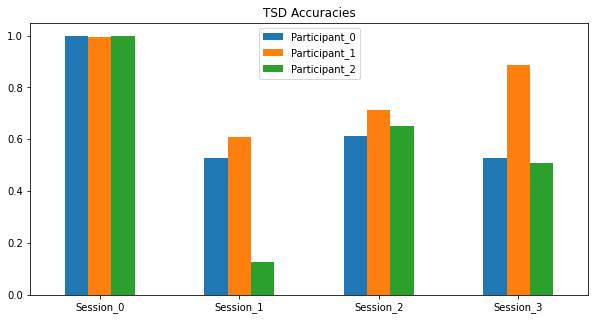

In [12]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

# 2. Domain Adverserial Neural Network (DANN)
* 2 domians : source(0) and target(1) (output_domain includes 2 features)
    * source / validation: labeled; first training
    * target: unlabeled; others
    * train using one source and one target
* start training using TSD_DNN model params 
* DANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = crossEntropyLoss(pred_domain_source, label_source_domain)
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_domain_target = 0.5 * domain_loss_weight * loss_domain_target
    * loss_main = loss_main_source + loss_domain_target
    * loss_domain = loss_domain_source + loss_domain_target
   
### Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD
    * beat_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict     

In [13]:
from LongTermClassificationMain.TrainingsAndEvaluations.ForTrainingSessions.TSD_DNN.train_tsd_dnn_standard import \
    test_TSD_DNN_on_training_sessions
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_DA_spectrograms
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [14]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_DA import test_network_DA_algorithm

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [15]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [16]:
num_neurons = [200, 200, 200]
feature_vector_input_length = 385
gestures_to_remove = [5, 6, 9, 10]
gestures_to_remove = None
number_of_class = 11
number_of_cycle_for_first_training = 4
number_of_cycles_rest_of_training = 4
learning_rate = 0.002515

path_weights_fine_tuning = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "DANN_THREE_CYCLES_11Gestures_TSD"

In [17]:
train_DA_spectrograms(examples_datasets_train, labels_datasets_train, filter_size=None,
                      num_kernels=num_neurons, algo_name=algo_name,
                      path_weights_fine_tuning=path_weights_fine_tuning,
                      gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
                      number_of_cycle_for_first_training=number_of_cycle_for_first_training,
                      number_of_cycles_rest_of_training=number_of_cycles_rest_of_training,
                      batch_size=128, spectrogram_model=False,
                      feature_vector_input_length=feature_vector_input_length,
                      path_weights_to_save_to="Weights_TSD/weights_", learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2674, 385)
(4,)   1
SHAPE X:  (2829, 385)
(4,)   2
SHAPE X:  (2881, 385)
(4,)   3
SHAPE X:  (2821, 385)
(4,)   0
SHAPE X:  (2970, 385)
(4,)   1
SHAPE X:  (2859, 385)
(4,)   2
SHAPE X:  (2837, 385)
(4,)   3
SHAPE X:  (2783, 385)
(4,)   0
SHAPE X:  (2816, 385)
(4,)   1
SHAPE X:  (2888, 385)
(4,)   2
SHAPE X:  (2864, 385)
(4,)   3
SHAPE X:  (2835, 385)
SHAPE SESSIONS:  (4,)
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        

Accuracy source 0.965625, main loss classifier 0.147801, source classification loss 0.124181, loss domain distinction 0.630400, accuracy domain distinction 0.491992
VALIDATION Loss: 0.32975507 Acc: 0.90604027
New best validation loss:  0.3297550678253174
Epoch 1 of 500 took 0.360s
Accuracy source 0.962891, main loss classifier 0.140333, source classification loss 0.129381, loss domain distinction 0.452247, accuracy domain distinction 0.487305
VALIDATION Loss: 0.18711984 Acc: 0.94630872
New best validation loss:  0.18711984157562256
Epoch 2 of 500 took 0.360s
Accuracy source 0.971094, main loss classifier 0.125033, source classification loss 0.107222, loss domain distinction 0.352448, accuracy domain distinction 0.493359
VALIDATION Loss: 0.28424057 Acc: 0.90604027
Epoch 3 of 500 took 0.357s
Accuracy source 0.962500, main loss classifier 0.134852, source classification loss 0.129568, loss domain distinction 0.292333, accuracy domain distinction 0.496680
VALIDATION Loss: 0.23534290 Acc: 0

Accuracy source 0.964063, main loss classifier 0.130986, source classification loss 0.118535, loss domain distinction 0.219826, accuracy domain distinction 0.499023
VALIDATION Loss: 0.31954473 Acc: 0.90268456
Epoch 11 of 500 took 0.366s
Accuracy source 0.975000, main loss classifier 0.124739, source classification loss 0.107369, loss domain distinction 0.213471, accuracy domain distinction 0.499414
VALIDATION Loss: 0.32862502 Acc: 0.89261745
Epoch    48: reducing learning rate of group 0 to 4.0240e-06.
Epoch 12 of 500 took 0.358s
Accuracy source 0.963672, main loss classifier 0.131391, source classification loss 0.120329, loss domain distinction 0.214582, accuracy domain distinction 0.498828
VALIDATION Loss: 0.33730108 Acc: 0.89932886
Epoch 13 of 500 took 0.361s
Accuracy source 0.971875, main loss classifier 0.126166, source classification loss 0.109382, loss domain distinction 0.212088, accuracy domain distinction 0.499805
VALIDATION Loss: 0.30506587 Acc: 0.90604027
Training complete 

Accuracy source 0.985085, main loss classifier 0.107260, source classification loss 0.052097, loss domain distinction 0.498805, accuracy domain distinction 0.492010
VALIDATION Loss: 0.05942513 Acc: 0.98181818
Epoch 19 of 500 took 0.395s
Accuracy source 0.983665, main loss classifier 0.109930, source classification loss 0.054488, loss domain distinction 0.510078, accuracy domain distinction 0.498402
VALIDATION Loss: 0.06378748 Acc: 0.97878788
Epoch 20 of 500 took 0.394s
Accuracy source 0.979403, main loss classifier 0.114489, source classification loss 0.061978, loss domain distinction 0.514666, accuracy domain distinction 0.490589
VALIDATION Loss: 0.08037190 Acc: 0.97272727
Epoch 21 of 500 took 0.401s
Accuracy source 0.987926, main loss classifier 0.105916, source classification loss 0.046753, loss domain distinction 0.503803, accuracy domain distinction 0.491122
VALIDATION Loss: 0.07590169 Acc: 0.96969697
Epoch 22 of 500 took 0.397s
Accuracy source 0.986151, main loss classifier 0.105

Accuracy source 0.982955, main loss classifier 0.110761, source classification loss 0.055418, loss domain distinction 0.511972, accuracy domain distinction 0.492898
VALIDATION Loss: 0.06692187 Acc: 0.97878788
Epoch 17 of 500 took 0.396s
Accuracy source 0.986151, main loss classifier 0.112231, source classification loss 0.056018, loss domain distinction 0.521002, accuracy domain distinction 0.484020
VALIDATION Loss: 0.06169170 Acc: 0.97878788
Epoch    66: reducing learning rate of group 0 to 1.6096e-07.
Epoch 18 of 500 took 0.396s
Accuracy source 0.985440, main loss classifier 0.110109, source classification loss 0.052787, loss domain distinction 0.516749, accuracy domain distinction 0.495561
VALIDATION Loss: 0.13805977 Acc: 0.95151515
Training complete in 0m 8s
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_

Accuracy source 0.986979, main loss classifier 0.106260, source classification loss 0.045601, loss domain distinction 0.517735, accuracy domain distinction 0.500186
VALIDATION Loss: 0.11156059 Acc: 0.96060606
Epoch 20 of 500 took 0.378s
Accuracy source 0.983259, main loss classifier 0.110275, source classification loss 0.052800, loss domain distinction 0.522826, accuracy domain distinction 0.499070
VALIDATION Loss: 0.02874412 Acc: 0.99393939
New best validation loss:  0.02874411642551422
Epoch 21 of 500 took 0.381s
Accuracy source 0.986979, main loss classifier 0.108276, source classification loss 0.050858, loss domain distinction 0.509632, accuracy domain distinction 0.503906
VALIDATION Loss: 0.04489513 Acc: 0.99090909
Epoch 22 of 500 took 0.378s
Accuracy source 0.984747, main loss classifier 0.110125, source classification loss 0.053611, loss domain distinction 0.515095, accuracy domain distinction 0.496466
VALIDATION Loss: 0.05642430 Acc: 0.98181818
Epoch 23 of 500 took 0.379s
Accur

Accuracy source 0.976918, main loss classifier 0.115756, source classification loss 0.076393, loss domain distinction 0.481283, accuracy domain distinction 0.501243
VALIDATION Loss: 2.65735507 Acc: 0.57188498
Epoch 11 of 500 took 0.396s
Accuracy source 0.980824, main loss classifier 0.111532, source classification loss 0.067135, loss domain distinction 0.479075, accuracy domain distinction 0.492720
VALIDATION Loss: 2.40660620 Acc: 0.58466454
Epoch    50: reducing learning rate of group 0 to 8.0480e-07.
Epoch 12 of 500 took 0.397s
Accuracy source 0.977983, main loss classifier 0.115177, source classification loss 0.077556, loss domain distinction 0.464795, accuracy domain distinction 0.502841
VALIDATION Loss: 2.86122680 Acc: 0.54952077
Epoch 13 of 500 took 0.396s
Accuracy source 0.982244, main loss classifier 0.109027, source classification loss 0.063560, loss domain distinction 0.472772, accuracy domain distinction 0.496804
VALIDATION Loss: 2.74755597 Acc: 0.55591054
Epoch 14 of 500 to

Accuracy source 0.979403, main loss classifier 0.134644, source classification loss 0.071646, loss domain distinction 0.795857, accuracy domain distinction 0.499822
VALIDATION Loss: 0.21237849 Acc: 0.91054313
New best validation loss:  0.21237848699092865
Epoch 1 of 500 took 0.397s
Accuracy source 0.980114, main loss classifier 0.130679, source classification loss 0.074968, loss domain distinction 0.728075, accuracy domain distinction 0.508523
VALIDATION Loss: 0.31271115 Acc: 0.87220447
Epoch 2 of 500 took 0.393s
Accuracy source 0.981179, main loss classifier 0.120492, source classification loss 0.062804, loss domain distinction 0.667305, accuracy domain distinction 0.507102
VALIDATION Loss: 0.22237128 Acc: 0.91373802
Epoch 3 of 500 took 0.392s
Accuracy source 0.981179, main loss classifier 0.121640, source classification loss 0.069545, loss domain distinction 0.626223, accuracy domain distinction 0.493430
VALIDATION Loss: 0.21701893 Acc: 0.91054313
Epoch 4 of 500 took 0.394s
Accuracy 

In [18]:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)   
test_network_DA_algorithm(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_neurons, path_weights_DA='Weights_TSD/weights_' + algo_name,
                              algo_name=algo_name,
                              path_weights_normal=path_weights_fine_tuning,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
                              cycle_to_test=3)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

In [19]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

DANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    DANN_acc[i] = acc
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
DANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.998028,0.610619,0.782772,0.645377
Participant_1,0.995463,0.666352,0.746356,0.883104
Participant_2,0.997015,0.173669,0.843045,0.776735


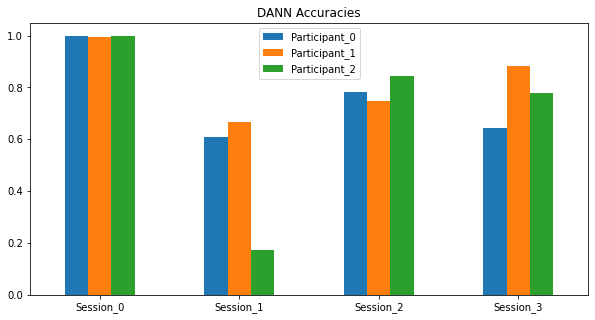

In [20]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

# 3. SCADANN
* start training using TSD_DNN model params for the first training seesion, then using DANN model params 
* first traning = labeled, others = pseudo labels 
    * train using one lebaled and n psuedo labeled (n = #session)
* use all training data at once
* pseudo_labels_heuristic
    * window_stable_mode_length = 30 (hold stable for 1.5s)
    * percentage_same_gesture_now_stable = 65% (remove examples that are likely to generate false pseudo labels)
    * maximum_length_instability_gesture_transition = 40
    * maximum_length_instability_same_gesture = 40 (remove examples that are unstable for more than 2s)
* SCADANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = ((1 - alpha) * crossEntropyLoss(pred_domain_source, label_source_domain))
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_main_target = (0.5 * loss_target_class + domain_loss_weight * loss_domain_target)
    * loss_main = loss_main_source + loss_main_target
    * loss_domain = loss_domain_source + loss_domain_target

   

### Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN
* beat_state_n.pt (n = # training session)
    * epoch: #epochs
    * model state_dict
    * optimizer state_dict
    * scheduler state_dict     

In [21]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import load_checkpoint
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.load_dataset_spectrogram_in_dataloader import \
    load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.self_learning.self_learning_utils import \
    generate_dataloaders_for_SCADANN
from LongTermClassificationMain.Models.model_training_self_learning import SCADANN_BN_training


In [22]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from SCADANN_TSD_DNN_training_session import run_SCADANN_training_sessions, test_network_SLADANN
batch_size = 256

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [23]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)
examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [24]:
num_neurons = [200, 200, 200]
learning_rate = 0.002515
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11
percentage_same_gesture_stable = 0.65  # 0.65 for 11 gestures, 0.85 for 7 gestures
path_weight_to_save_to = "Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN"
path_weights_start_with = "Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD"
path_weights_Normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "SCADANN_THREE_CYCLES_11Gestures_TSD"

In [25]:
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
                              num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
                              path_weights_to_save_to=path_weight_to_save_to,
                              path_weights_Adversarial_training=path_weights_start_with,
                              path_weights_Normal_training=path_weights_Normal_training,
                              number_of_cycle_for_first_training=4, number_of_cycles_rest_of_training=4,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
                              learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2972, 385)
(4,)   1
SHAPE X:  (3144, 385)
(4,)   2
SHAPE X:  (3202, 385)
(4,)   3
SHAPE X:  (3135, 385)
(4,)   0
SHAPE X:  (3300, 385)
(4,)   1
SHAPE X:  (3177, 385)
(4,)   2
SHAPE X:  (3153, 385)
(4,)   3
SHAPE X:  (3093, 385)
(4,)   0
SHAPE X:  (3129, 385)
(4,)   1
SHAPE X:  (3209, 385)
(4,)   2
SHAPE X:  (3183, 385)
(4,)   3
SHAPE X:  (3150, 385)
participants_train =  3
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (

BEFORE:  0.8617021276595744   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  1.0   AFTER:  1.0  len before:  95   len after:  95
BEFORE:  0.5360824742268041   AFTER:  0.6597938144329897  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  90   len after:  90
BEFORE:  0.18556701030927836   AFTER:  0.0  len before:  97   len after:  73
BEFORE:  0.5344827586206896   AFTER:  1.0  len before:  58   len after:  31
BEFORE:  0.6701030927835051   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.38144329896907214   AFTER:  1.0  len before:  97   len after:  64
BEFORE:  0.5773195876288659   AFTER:  0.6494845360824743  len before:  97   len after:  97
BEFORE:  0.31683168316831684   AFTER:  0.0  len before:  101   len after:  80
ACCURACY MODEL:  0.6618956743002544   Accuracy pseudo: 0.7978084128667373  len pseudo:  2829    len predictions 3144
STARTING TRAINING
Accuracy total 0.848437, main loss classifier 0.729141, source accuracy 0.955357 source classificatio

Accuracy total 0.891071, main loss classifier 0.494064, source accuracy 0.958929 source classification loss 0.142988, target accuracy 0.823214 target loss 0.624358 accuracy domain distinction 0.499107 loss domain distinction 1.103915,
VALIDATION Loss: 0.44557138 Acc: 0.8639576
Epoch 25 of 500 took 0.581s
Accuracy total 0.898884, main loss classifier 0.468244, source accuracy 0.959821 source classification loss 0.152708, target accuracy 0.837946 target loss 0.565766 accuracy domain distinction 0.501116 loss domain distinction 1.090069,
VALIDATION Loss: 0.47632386 Acc: 0.86572438
Epoch 26 of 500 took 0.588s
Accuracy total 0.900000, main loss classifier 0.474855, source accuracy 0.958482 source classification loss 0.146848, target accuracy 0.841518 target loss 0.580906 accuracy domain distinction 0.501116 loss domain distinction 1.109779,
VALIDATION Loss: 0.45290990 Acc: 0.84628975
Epoch 27 of 500 took 0.586s
Accuracy total 0.894866, main loss classifier 0.474374, source accuracy 0.955804

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.3917525773195876   AFTER:  nan  len before:  97   len after:  0
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.1134020618556701   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9690721649484536   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  73
BEFORE:  0.9072164948453608   AFTER:  1.0  len before:  97   len after:  71
BEFORE:  0.10309278350515463   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.16494845360824742   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.969

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Accuracy total 0.863176, main loss classifier 0.596946, source accuracy 0.845861 source classification loss 0.565268, target accuracy 0.880490 target loss 0.407493 accuracy domain distinction 0.494721 loss domain distinction 1.105657,
VALIDATION Loss: 0.24803407 Acc: 0.93853821
New best validation loss:  0.24803407043218612
Epoch 2 of 500 took 0.623s
Accuracy total 0.881757, main loss classifier 0.511560, source accuracy 0.864443 source classification loss 0.457709, target accuracy 0.899071 target loss 0.340847 accuracy domain distinction 0.497889 loss domain distinction 1.122815,
VALIDATION Loss: 0.22878025 Acc: 0.93023256
New best validation loss:  0.22878025397658347
Epoch 3 of 500 took 0.619s
Accuracy total 0.897804, main loss classifier 0.460349, source accuracy 0.885135 source classification loss 0.409046, target accuracy 0.910473 target loss 0.287741 accuracy domain distinction 0.498944 loss domain distinction 1.119552,
VALIDATION Loss: 0.18879838 Acc: 0.9551495
New best validat

Accuracy total 0.923142, main loss classifier 0.361149, source accuracy 0.908784 source classification loss 0.298888, target accuracy 0.937500 target loss 0.208120 accuracy domain distinction 0.499155 loss domain distinction 1.076449,
VALIDATION Loss: 0.13833303 Acc: 0.95681063
Epoch 28 of 500 took 0.624s
Accuracy total 0.920186, main loss classifier 0.361484, source accuracy 0.905405 source classification loss 0.301806, target accuracy 0.934966 target loss 0.207309 accuracy domain distinction 0.500422 loss domain distinction 1.069266,
VALIDATION Loss: 0.14072871 Acc: 0.96013289
Epoch 29 of 500 took 0.621s
Training complete in 0m 17s
['participant_1', 'participant_2', 'participant_0']
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.3917525773195876   AFTER:  nan  len before:  97   len after:  0
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.1134020618556701   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9690721649484536   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  73
BEFORE:  0.9072164948453608   AFTER:  1.0  len before:  97   len after:  71
BEFORE:  0.10309278350515463   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.16494845360824742   AFTER:  0.0  len before:  97   len after:  97
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.969

Accuracy total 0.903795, main loss classifier 0.436596, source accuracy 0.893304 source classification loss 0.351960, target accuracy 0.914286 target loss 0.305665 accuracy domain distinction 0.500893 loss domain distinction 1.077833,
VALIDATION Loss: 0.19737449 Acc: 0.94045534
Epoch 11 of 500 took 0.595s
Accuracy total 0.907366, main loss classifier 0.405145, source accuracy 0.908482 source classification loss 0.289143, target accuracy 0.906250 target loss 0.304169 accuracy domain distinction 0.498884 loss domain distinction 1.084888,
VALIDATION Loss: 0.17096031 Acc: 0.95271454
New best validation loss:  0.17096030629343456
Epoch 12 of 500 took 0.588s
Accuracy total 0.909598, main loss classifier 0.415642, source accuracy 0.907589 source classification loss 0.319890, target accuracy 0.911607 target loss 0.293123 accuracy domain distinction 0.500223 loss domain distinction 1.091354,
VALIDATION Loss: 0.19582330 Acc: 0.9352014
Epoch 13 of 500 took 0.591s
Accuracy total 0.900000, main los

Accuracy total 0.912500, main loss classifier 0.393433, source accuracy 0.900446 source classification loss 0.322773, target accuracy 0.924554 target loss 0.252542 accuracy domain distinction 0.500223 loss domain distinction 1.057759,
VALIDATION Loss: 0.14942522 Acc: 0.95621716
Epoch 37 of 500 took 0.585s
Accuracy total 0.919866, main loss classifier 0.375445, source accuracy 0.908036 source classification loss 0.294249, target accuracy 0.931696 target loss 0.245478 accuracy domain distinction 0.500223 loss domain distinction 1.055819,
VALIDATION Loss: 0.15799122 Acc: 0.95446585
Epoch 38 of 500 took 0.584s
Accuracy total 0.924777, main loss classifier 0.363091, source accuracy 0.918304 source classification loss 0.276734, target accuracy 0.931250 target loss 0.240497 accuracy domain distinction 0.501563 loss domain distinction 1.044760,
VALIDATION Loss: 0.15468513 Acc: 0.95621716
Epoch 39 of 500 took 0.584s
Training complete in 0m 22s
['participant_1', 'participant_2', 'participant_0']

STARTING TRAINING
Accuracy total 0.872013, main loss classifier 0.683488, source accuracy 0.984835 source classification loss 0.056084, target accuracy 0.759191 target loss 1.075270 accuracy domain distinction 0.494715 loss domain distinction 1.178109,
VALIDATION Loss: 0.67427704 Acc: 0.82468694
New best validation loss:  0.674277040693495
Epoch 2 of 500 took 0.574s
Accuracy total 0.868566, main loss classifier 0.674376, source accuracy 0.976562 source classification loss 0.067395, target accuracy 0.760570 target loss 1.048449 accuracy domain distinction 0.492647 loss domain distinction 1.164541,
VALIDATION Loss: 1.17536616 Acc: 0.74060823
Epoch 3 of 500 took 0.574s
Accuracy total 0.874770, main loss classifier 0.657232, source accuracy 0.978860 source classification loss 0.065549, target accuracy 0.770680 target loss 1.015242 accuracy domain distinction 0.497243 loss domain distinction 1.168364,
VALIDATION Loss: 1.16692461 Acc: 0.74060823
Epoch 4 of 500 took 0.572s
Accuracy total 0.87

Accuracy total 0.877757, main loss classifier 0.633004, source accuracy 0.979779 source classification loss 0.063057, target accuracy 0.775735 target loss 0.966736 accuracy domain distinction 0.491039 loss domain distinction 1.181076,
VALIDATION Loss: 0.70365380 Acc: 0.83899821
Epoch 28 of 500 took 0.570s
Accuracy total 0.871094, main loss classifier 0.668156, source accuracy 0.980699 source classification loss 0.067698, target accuracy 0.761489 target loss 1.031463 accuracy domain distinction 0.487592 loss domain distinction 1.185762,
VALIDATION Loss: 0.93777250 Acc: 0.76565295
Epoch 29 of 500 took 0.578s
Accuracy total 0.875689, main loss classifier 0.628527, source accuracy 0.984375 source classification loss 0.053477, target accuracy 0.767004 target loss 0.969924 accuracy domain distinction 0.495175 loss domain distinction 1.168260,
VALIDATION Loss: 0.77455992 Acc: 0.81216458
Epoch 30 of 500 took 0.573s
Accuracy total 0.884421, main loss classifier 0.626963, source accuracy 0.98851

BEFORE:  0.9361702127659575   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.845360824742268   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.3191489361702128   AFTER:  0.6  len before:  94   len after:  50
BEFORE:  0.13402061855670103   AFTER:  0.0  len before:  97   len after:  97
ACCURACY MODEL:  0.6984576644633302   Accuracy pseudo: 0.7887576083064805  len pseudo:  2793    len predictions 3177
HANDLING NEW SESSION  2
Finish segment dataset
Finish pseudo_labels
BEFORE:  0.4536082474226804   AFTER:  1.0  len before:  97   len after:  68
BEFORE:  0.9278350515463918   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.3917525773195876   AFTER:  0.4722222222222222  len before:  97   len after:  72
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9893617021276596   AFTER:  1.0  len before:  94   len after

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.4536082474226804   AFTER:  1.0  len before:  97   len after:  68
BEFORE:  0.9278350515463918   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.3917525773195876   AFTER:  0.4722222222222222  len before:  97   len after:  72
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9893617021276596   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.7938144329896907   AFTER:  1.0  len before:  97   len after:  73
BEFORE:  0.9690721649484536   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.41237113402061853   AFTER:  0.0  len before:  97   len after:  72
BEFORE:  0.9285714285714286   AFTER:  1.0  len before:  98   len after:  71
BEFORE:  0.422680412371134   AFTER:  0.4189189189189189  len before:  97   len after:  74
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  72
BEFORE:  0.022222222222222223

Accuracy total 0.861698, main loss classifier 0.754842, source accuracy 0.861486 source classification loss 0.561953, target accuracy 0.861909 target loss 0.708605 accuracy domain distinction 0.505490 loss domain distinction 1.195629,
VALIDATION Loss: 0.38067925 Acc: 0.91059603
Epoch 11 of 500 took 0.621s
Accuracy total 0.865921, main loss classifier 0.733128, source accuracy 0.876689 source classification loss 0.496411, target accuracy 0.855152 target loss 0.732276 accuracy domain distinction 0.508868 loss domain distinction 1.187843,
VALIDATION Loss: 0.37801141 Acc: 0.90562914
Epoch 12 of 500 took 0.626s
Accuracy total 0.864231, main loss classifier 0.754139, source accuracy 0.859797 source classification loss 0.577487, target accuracy 0.868666 target loss 0.691488 accuracy domain distinction 0.501478 loss domain distinction 1.196508,
VALIDATION Loss: 0.28702136 Acc: 0.91887417
New best validation loss:  0.2870213627815247
Epoch 13 of 500 took 0.620s
Accuracy total 0.860853, main los

STARTING TRAINING
Accuracy total 0.767361, main loss classifier 1.148564, source accuracy 0.974537 source classification loss 0.078297, target accuracy 0.560185 target loss 1.991136 accuracy domain distinction 0.493924 loss domain distinction 1.138468,
VALIDATION Loss: 0.98626638 Acc: 0.72374429
New best validation loss:  0.986266383102962
Epoch 2 of 500 took 0.503s
Accuracy total 0.800637, main loss classifier 0.964093, source accuracy 0.968171 source classification loss 0.097764, target accuracy 0.633102 target loss 1.607708 accuracy domain distinction 0.503183 loss domain distinction 1.113567,
VALIDATION Loss: 0.73080934 Acc: 0.79452055
New best validation loss:  0.7308093394551959
Epoch 3 of 500 took 0.452s
Accuracy total 0.813368, main loss classifier 0.878555, source accuracy 0.976273 source classification loss 0.090434, target accuracy 0.650463 target loss 1.443227 accuracy domain distinction 0.515046 loss domain distinction 1.117246,
VALIDATION Loss: 1.01572244 Acc: 0.71004566


Accuracy total 0.862558, main loss classifier 0.589961, source accuracy 0.961227 source classification loss 0.134833, target accuracy 0.763889 target loss 0.820638 accuracy domain distinction 0.504630 loss domain distinction 1.122252,
VALIDATION Loss: 0.47760792 Acc: 0.87214612
Epoch 28 of 500 took 0.451s
Accuracy total 0.864005, main loss classifier 0.549679, source accuracy 0.959491 source classification loss 0.121818, target accuracy 0.768519 target loss 0.753741 accuracy domain distinction 0.500000 loss domain distinction 1.119000,
VALIDATION Loss: 0.51913896 Acc: 0.85616438
Epoch 29 of 500 took 0.452s
Accuracy total 0.868345, main loss classifier 0.552918, source accuracy 0.958333 source classification loss 0.127381, target accuracy 0.778356 target loss 0.757313 accuracy domain distinction 0.500579 loss domain distinction 1.105711,
VALIDATION Loss: 0.41361846 Acc: 0.88127854
Epoch    29: reducing learning rate of group 0 to 4.0240e-06.
Epoch 30 of 500 took 0.452s
Accuracy total 0.

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9893617021276596   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9278350515463918   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9680851063829787   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.7422680412371134   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.422680412371134   AFTER:  1.0  len before:  97   len after:  61
BEFORE:  0.7628865979381443   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.6170212765957447   AFTER:  1.0  len before:  94   len after:  74
BEFORE:  0.9278350515463918   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.5257731958762887   AFTER:  1.0  len before:  97   len after:  74
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.886

Accuracy total 0.873481, main loss classifier 0.518239, source accuracy 0.865451 source classification loss 0.434163, target accuracy 0.881510 target loss 0.377009 accuracy domain distinction 0.502821 loss domain distinction 1.126529,
VALIDATION Loss: 0.29028089 Acc: 0.91878173
Epoch 20 of 500 took 0.602s
Accuracy total 0.876736, main loss classifier 0.509754, source accuracy 0.866319 source classification loss 0.422011, target accuracy 0.887153 target loss 0.372258 accuracy domain distinction 0.500868 loss domain distinction 1.126200,
VALIDATION Loss: 0.32315260 Acc: 0.9035533
Epoch 21 of 500 took 0.601s
Training complete in 0m 12s
['participant_1', 'participant_2', 'participant_0']
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
   

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9893617021276596   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9278350515463918   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9680851063829787   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.7422680412371134   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.422680412371134   AFTER:  1.0  len before:  97   len after:  61
BEFORE:  0.7628865979381443   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.6170212765957447   AFTER:  1.0  len before:  94   len after:  74
BEFORE:  0.9278350515463918   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.5257731958762887   AFTER:  1.0  len before:  97   len after:  74
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.886

Accuracy total 0.769196, main loss classifier 1.028904, source accuracy 0.737054 source classification loss 1.112061, target accuracy 0.801339 target loss 0.723455 accuracy domain distinction 0.497098 loss domain distinction 1.111456,
VALIDATION Loss: 0.41706422 Acc: 0.88035714
New best validation loss:  0.41706422136889565
Epoch 11 of 500 took 0.588s
Accuracy total 0.779911, main loss classifier 0.992862, source accuracy 0.756250 source classification loss 1.024390, target accuracy 0.803571 target loss 0.739234 accuracy domain distinction 0.496652 loss domain distinction 1.110496,
VALIDATION Loss: 0.40697444 Acc: 0.88392857
New best validation loss:  0.406974443131023
Epoch 12 of 500 took 0.601s
Accuracy total 0.785714, main loss classifier 0.957813, source accuracy 0.754018 source classification loss 0.999517, target accuracy 0.817411 target loss 0.695694 accuracy domain distinction 0.499554 loss domain distinction 1.102072,
VALIDATION Loss: 0.42588275 Acc: 0.87321429
Epoch 13 of 500

In [26]:
path_weights_normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
                     path_weights_ASR=path_weight_to_save_to, path_weights_normal=path_weights_normal_training,
                     algo_name=algo_name, cycle_test=3, gestures_to_remove=gestures_to_remove,
                     number_of_classes=number_of_classes)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

In [27]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

SCADANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    SCADANN_acc[i] = acc
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
SCADANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.998028,0.711898,0.809925,0.702574
Participant_1,0.995463,0.686200,0.772595,0.880157
Participant_2,0.997015,0.149393,0.899436,0.813321


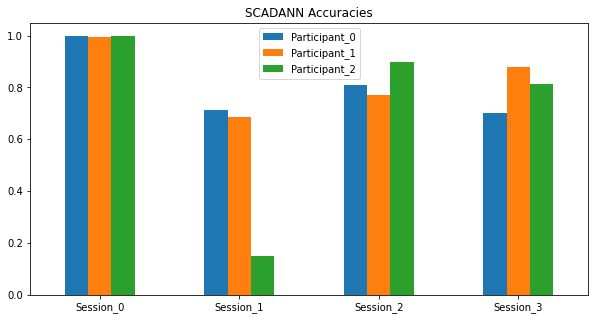

In [28]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

# Conclusion

In [29]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.679239
DANN,0.759878
SCADANN,0.784667


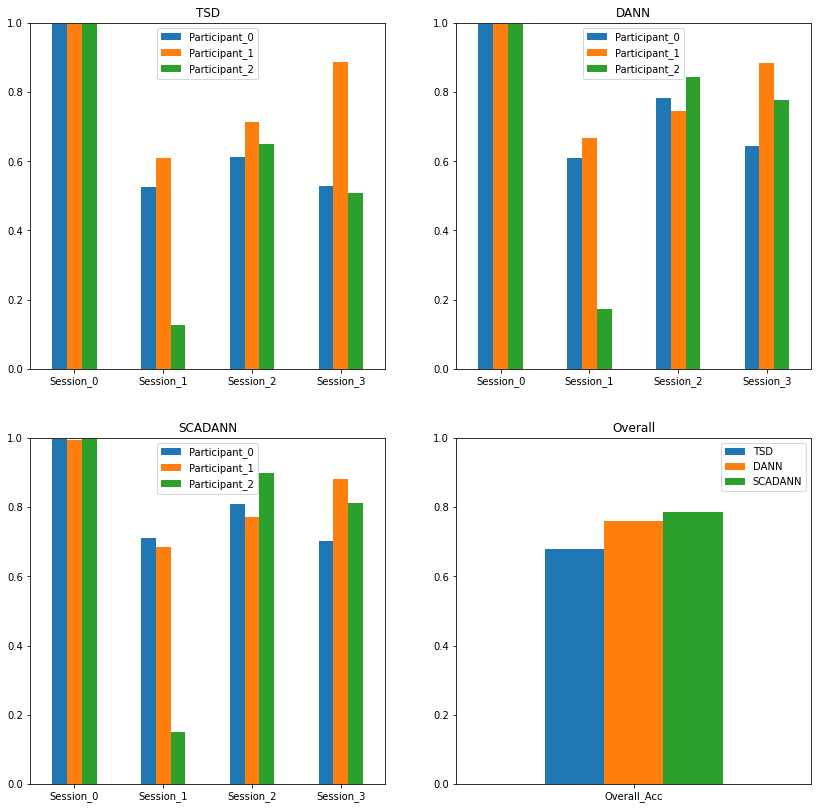

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])